In [1]:
# 1. Imports & Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
import joblib

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

In [2]:
file_path = '/content/electric_vehicle_analytics.csv'  # upload your file here
df = pd.read_csv(file_path)
print("Dataset shape:", df.shape)
df.head(10)

Dataset shape: (3000, 25)


,Vehicle_ID,Make,Model,Year,Region,Vehicle_Type,Battery_Capacity_kWh,Battery_Health_%,Range_km,Charging_Power_kW,Charging_Time_hr,Charge_Cycles,Energy_Consumption_kWh_per_100km,Mileage_km,Avg_Speed_kmh,Max_Speed_kmh,Acceleration_0_100_kmh_sec,Temperature_C,Usage_Type,CO2_Saved_tons,Maintenance_Cost_USD,Insurance_Cost_USD,Electricity_Cost_USD_per_kWh,Monthly_Charging_Cost_USD,Resale_Value_USD
0,1,Nissan,Leaf,2021,Asia,SUV,101.7,75.5,565,153.6,0.82,1438,12.76,117727,53.4,233,8.10,-9.0,Personal,14.13,969,843,0.30,375.55,26483
1,2,Nissan,Leaf,2020,Australia,Sedan,30.1,99.8,157,157.2,0.27,1056,15.79,161730,58.0,221,9.83,1.6,Personal,19.41,1157,1186,0.25,532.02,11287
2,3,Hyundai,Kona Electric,2021,North America,SUV,118.5,84.0,677,173.6,0.84,1497,24.34,244931,69.4,138,3.60,1.5,Fleet,29.39,291,1890,0.26,1291.68,34023
3,4,Audi,Q4 e-tron,2022,Europe,Hatchback,33.1,97.3,149,169.3,0.25,1613,14.70,57995,42.9,192,8.97,12.5,Fleet,6.96,401,2481,0.33,234.44,14398
4,5,Tesla,Model 3,2022,Australia,Truck,81.3,85.6,481,212.8,0.43,1078,22.77,17185,97.6,189,7.03,-3.0,Commercial,2.06,214,2336,0.10,32.61,23033
5,6,Hyundai,Ioniq 5,2021,North America,Sedan,68.1,81.8,312,14.4,6.31,591,21.48,134312,72.4,235,5.83,-4.2,Commercial,16.12,334,700,0.25,601.05,19412
6,7,Ford,F-150 Lightning,2016,Asia,Sedan,38.6,81.1,206,170.2,0.27,925,23.53,206664,56.8,176,8.14,28.0,Fleet,24.80,1441,1002,0.29,1175.18,13983
7,8,Audi,e-tron,2021,Australia,Sedan,33.6,91.3,141,116.0,0.39,1063,20.27,112059,69.4,133,9.40,2.5,Fleet,13.45,948,2178,0.28,530.00,14121
8,9,Mercedes,EQS,2018,Europe,Sedan,114.9,88.0,619,221.4,0.61,1797,20.23,7693,62.0,237,4.71,34.6,Personal,0.92,1554,2163,0.30,38.91,31897
9,10,Hyundai,Ioniq 5,2023,North America,SUV,58.6,73.3,261,113.1,0.57,1968,15.96,194125,65.8,138,6.65,24.6,Personal,23.30,1457,1183,0.15,387.28,20833


In [3]:
# 3. Data Overview
print("\nColumn names:", df.columns.tolist())
print("\nData types and non-null counts:")
print(df.info())
print("\nStatistical summary of numeric columns:")
print(df.describe())
print("\nMissing values by column:")
print(df.isnull().sum().sort_values(ascending=False).head(20))



Column names: ['Vehicle_ID', 'Make', 'Model', 'Year', 'Region', 'Vehicle_Type', 'Battery_Capacity_kWh', 'Battery_Health_%', 'Range_km', 'Charging_Power_kW', 'Charging_Time_hr', 'Charge_Cycles', 'Energy_Consumption_kWh_per_100km', 'Mileage_km', 'Avg_Speed_kmh', 'Max_Speed_kmh', 'Acceleration_0_100_kmh_sec', 'Temperature_C', 'Usage_Type', 'CO2_Saved_tons', 'Maintenance_Cost_USD', 'Insurance_Cost_USD', 'Electricity_Cost_USD_per_kWh', 'Monthly_Charging_Cost_USD', 'Resale_Value_USD']

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Vehicle_ID                        3000 non-null   int64  
 1   Make                              3000 non-null   object 
 2   Model                             3000 non-null   object 
 3   Year                              3000 non-null   int64

In [4]:
target = 'Range_km'
df = df.dropna(subset=[target])

# Example: create vehicle age (assuming you have 'Model_Year')
current_year = 2025
if 'Model_Year' in df.columns:
    df['Vehicle_Age'] = current_year - df['Model_Year']
else:
    print("Column 'Model_Year' not found; skipping age calculation.")

# Filter out unrealistic values (adjust columns accordingly)
if 'Base_Price' in df.columns:
    df = df[(df['Base_Price'] > 0) & (df[target] > 0)]
else:
    df = df[df[target] > 0]

# Select a subset of columns for modelling (replace with your actual columns)
features = []
for col in ['Make', 'Model', 'Vehicle_Type', 'Battery_Capacity_kWh', 'Vehicle_Age', 'Base_Price']:
    if col in df.columns:
        features.append(col)
    else:
        print(f"Column {col} not found; will skip it.")

# Prepare final dataframe
df_model = df[features + [target]].copy()
print("\nFinal modelling dataset shape:", df_model.shape)
print(df_model.head(5))

Column 'Model_Year' not found; skipping age calculation.
Column Vehicle_Age not found; will skip it.
Column Base_Price not found; will skip it.

Final modelling dataset shape: (3000, 5)
      Make          Model Vehicle_Type  Battery_Capacity_kWh  Range_km
0   Nissan           Leaf          SUV                 101.7       565
1   Nissan           Leaf        Sedan                  30.1       157
2  Hyundai  Kona Electric          SUV                 118.5       677
3     Audi      Q4 e-tron    Hatchback                  33.1       149
4    Tesla        Model 3        Truck                  81.3       481


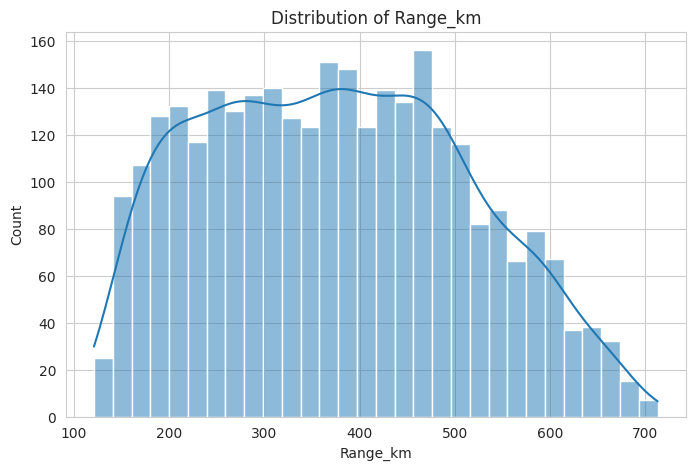

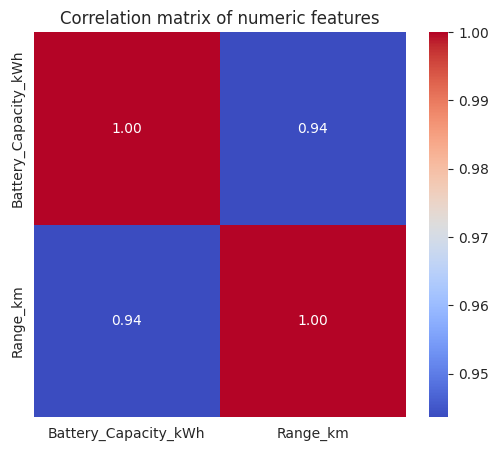

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df_model[target], bins=30, kde=True)
plt.title(f'Distribution of {target}')
plt.xlabel(target)
plt.ylabel('Count')
plt.show()

# Scatter plot: Price vs Range
if 'Base_Price' in df_model.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='Base_Price', y=target, hue='Make', data=df_model, alpha=0.6)
    plt.title('Base Price vs Electric Range by Make')
    plt.xlabel('Base Price')
    plt.ylabel(target)
    plt.show()

# Correlation heatmap for numeric features
numeric_cols = [c for c in ['Battery_Capacity_kWh', 'Vehicle_Age', 'Base_Price', target] if c in df_model.columns]
if len(numeric_cols) >= 2:
    plt.figure(figsize=(6,5))
    sns.heatmap(df_model[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation matrix of numeric features')
    plt.show()

In [6]:
X = df_model.drop(columns=[target])
y = df_model[target]

# Identify numeric & categorical features
numeric_features = [c for c in ['Battery_Capacity_kWh', 'Vehicle_Age', 'Base_Price'] if c in X.columns]
categorical_features = [c for c in ['Make', 'Model', 'Vehicle_Type'] if c in X.columns]

# Preprocessing pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTraining set size:", X_train.shape, "Test set size:", X_test.shape)

# Train model
model_pipeline.fit(X_train, y_train)

# Predict & evaluate
y_pred = model_pipeline.predict(X_test)
print("\nModel performance:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

# Feature importances (for tree-based model)
importances = model_pipeline.named_steps['regressor'].feature_importances_
print("\nFeature importances (raw):", importances)



Training set size: (2400, 4) Test set size: (600, 4)

Model performance:
MAE: 41.698239563492066
RMSE: 51.97500582802278
R2: 0.8515542341948138

Feature importances (raw): [9.37634312e-01 1.75983605e-03 1.62113918e-03 1.89529352e-03
 1.95231724e-03 1.73043728e-03 1.63630667e-03 1.78822672e-03
 1.67328383e-03 1.52309094e-03 1.67033661e-03 1.29917405e-03
 1.54714445e-03 1.48307767e-03 1.43172780e-03 1.56945742e-03
 1.63581870e-03 1.60094982e-03 1.15974865e-03 1.46588531e-03
 1.37651310e-03 2.08814544e-03 1.43293065e-03 7.03131044e-04
 8.04004722e-04 7.79494531e-04 1.10576009e-03 1.50017201e-03
 1.16431431e-03 1.45752384e-03 1.55539799e-03 8.11100981e-04
 1.22945827e-03 1.48914736e-03 3.65299729e-03 3.51316161e-03
 3.84243126e-03 3.41675123e-03]


In [7]:
if 'Base_Price' in df_model.columns:
    cluster_features = ['Base_Price', target]
    X_clust = df_model[cluster_features].dropna()
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(X_clust)
    df_model.loc[X_clust.index, 'Cluster'] = clusters

    plt.figure(figsize=(8,5))
    sns.scatterplot(x='Base_Price', y=target, hue='Cluster', data=df_model.loc[X_clust.index], palette='viridis')
    plt.title('Clustering: Base Price vs Range')
    plt.xlabel('Base Price')
    plt.ylabel(target)
    plt.show()

In [8]:
if ('Base_Price' in df_model.columns):
    df_model['Range_per_Price'] = df_model[target] / df_model['Base_Price']
    top5 = df_model.sort_values('Range_per_Price', ascending=False).head(5)
    print("\nTop 5 models by range per unit price:")
    print(top5[['Make','Model',target,'Base_Price','Range_per_Price']])

# Save cleaned dataset and model
df_model.to_csv('/content/cleaned_electric_vehicle_analytics.csv', index=False)
joblib.dump(model_pipeline, '/content/ev_range_model.pkl')
print("\nSaved cleaned dataset and model pipeline to Colab filesystem.")


Saved cleaned dataset and model pipeline to Colab filesystem.
